In [2]:
import os
import gc
import json
import time
import shutil
import random
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from loguru import logger
import ipyplot as iplt

from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import faiss

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


In [3]:
data_dir = Path("/data/a3-data/")
data_dir.exists()

True

In [4]:
df = pd.read_parquet(data_dir / "val.parquet")
df.label = df.label.astype("category").cat.codes
df

,id,merchant,image_url,product_name,description,merchant_deep_link,brand,category,gender,colour,style_code,gtin,image_urls,image,label,phash
0,schuh.f48ac80b3543bd44cd64a7dce6f00210,schuh,https://d2ob0iztsaxy5v.cloudfront.net/product/...,Converse Black & White All Star Dainty Gs Ox T...,The All Star Dainty GS Ox is just as it sounds...,https://www.schuh.co.uk/womens/converse-all-st...,Converse,Clothing & Accessories > Shoes > Women's Footwear,None,Black/white,None,"[888757138418.0, 5051571853668.0, 888757138432...",https://d2ob0iztsaxy5v.cloudfront.net/product/...,images/schuh/schuh.f48ac80b3543bd44cd64a7dce6f...,0,b8213cf9bcb4ce88d313e263c-b8213cf9bcb4ce88d313...
1,schuh.f48ac80b3543bd44cd64a7dce6f00210,schuh,https://d2ob0iztsaxy5v.cloudfront.net/product/...,Converse Black & White All Star Dainty Gs Ox T...,The All Star Dainty GS Ox is just as it sounds...,https://www.schuh.co.uk/womens/converse-all-st...,Converse,Clothing & Accessories > Shoes > Women's Footwear,None,Black/white,None,"[888757138418.0, 5051571853668.0, 888757138432...",https://d2ob0iztsaxy5v.cloudfront.net/product/...,images/schuh/schuh.f48ac80b3543bd44cd64a7dce6f...,0,a27b6dc86927b969a595858ca-a27a6dcc6927b969a595...
2,schuh.f48ac80b3543bd44cd64a7dce6f00210,schuh,https://d2ob0iztsaxy5v.cloudfront.net/product/...,Converse Black & White All Star Dainty Gs Ox T...,The All Star Dainty GS Ox is just as it sounds...,https://www.schuh.co.uk/womens/converse-all-st...,Converse,Clothing & Accessories > Shoes > Women's Footwear,None,Black/white,None,"[888757138418.0, 5051571853668.0, 888757138432...",https://d2ob0iztsaxy5v.cloudfront.net/product/...,images/schuh/schuh.f48ac80b3543bd44cd64a7dce6f...,0,aced9d24f6d21bd31b082e24e-ace59d24f6d21bd31b09...
3,asos.2b51258c6a126d1ec0eac9a6798ae882,asos,https://images.asos-media.com/products/adidas-...,adidas Originals Ozweego trainers in beige-Neu...,Trainers by adidas This item is excluded from ...,https://www.asos.com/adidas-originals/adidas-o...,adidas Originals,Women > Shoes > Trainers,female,Neutral,FX6029,"[4062065627901.0, 4062065627987.0, 40620656278...",https://images.asos-media.com/products/adidas-...,images/asos/asos.2b51258c6a126d1ec0eac9a6798ae...,1,bfc649b25eb60b3e89acc10f0-bfe649b25eb40b3e89ec...
4,asos.2b51258c6a126d1ec0eac9a6798ae882,asos,https://images.asos-media.com/products/adidas-...,adidas Originals Ozweego trainers in beige-Neu...,Trainers by adidas This item is excluded from ...,https://www.asos.com/adidas-originals/adidas-o...,adidas Originals,Women > Shoes > Trainers,female,Neutral,FX6029,"[4062065627901.0, 4062065627987.0, 40620656278...",https://images.asos-media.com/products/adidas-...,images/asos/asos.2b51258c6a126d1ec0eac9a6798ae...,1,bfa00a04fecb2a596da13b356-bfa00a04fecb2a596da1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7501,foot_locker.6195f128fdefecdb571b91649cf4c991,foot_locker,https://images.footlocker.com/is/image/FLEU/31...,Converse Run Star Hike Recycled Polyester Plat...,Explore our wide range of Casual Footwear with...,https://www.footlocker.co.uk/en/product/~/3155...,Converse,Footwear,None,Green,172726C,"[194433427807.0, 194433427821.0, 194433427838....",https://images.footlocker.com/is/image/FLEU/31...,images/foot_locker/foot_locker.6195f128fdefecd...,258,86078b850fbf88173cc337cd6-86078f850fbf88173cc2...
7502,foot_locker.6195f128fdefecdb571b91649cf4c991,foot_locker,https://images.footlocker.com/is/image/FLEU/31...,Converse Run Star Hike Recycled Polyester Plat...,Explore our wide range of Casual Footwear with...,https://www.footlocker.co.uk/en/product/~/3155...,Converse,Footwear,None,Green,172726C,"[194433427807.0, 194433427821.0, 194433427838....",https://images.footlocker.com/is/image/FLEU/31...,images/foot_locker/foot_locker.6195f128fdefecd...,258,c35a62d64e3127a38e5938e79-c35a43964e3127a38e79...
7503,foot_locker.6195f128fdefecdb571b91649cf4c991,foot_locker,https://images.footlocker.com/is/image/FLEU/31...,Converse Run Star Hike Recycled Polyester Plat.

In [5]:
model = timm.create_model("vit_base_resnet50_384", pretrained=True, num_classes=0)
model = model.eval().cuda()
model


VisionTransformer(
  (patch_embed): HybridEmbed(
    (backbone): ResNetV2(
      (stem): Sequential(
        (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (norm): GroupNormAct(
          32, 64, eps=1e-05, affine=True
          (act): ReLU(inplace=True)
        )
        (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
      )
      (stages): Sequential(
        (0): ResNetStage(
          (blocks): Sequential(
            (0): Bottleneck(
              (downsample): DownsampleConv(
                (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (norm): GroupNormAct(
                  32, 256, eps=1e-05, affine=True
                  (act): Identity()
                )
              )
              (conv1): StdConv2dSame(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm1): GroupNormAct(
                32, 64, eps=1e-05, 

In [6]:
transform = create_transform(**resolve_data_config({}, model=model))
transform

Compose(
    Resize(size=384, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)

In [7]:
class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def read_image(self, img):
        img = os.path.join(self.data_dir, img)
        img = Image.open(img).convert("RGB")
        return img

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.at[idx, "image"]
        img = self.read_image(img_path)
        if self.transform:
            img = self.transform(img)
        return img

dataset = ImageDataset(df, data_dir, transform)
dataset[0]

tensor([[[0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         ...,
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118]],

        [[0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         ...,
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118]],

        [[0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.8118],
         [0.8118, 0.8118, 0.8118,  ..., 0.8118, 0.8118, 0.

In [8]:
dataloader = DataLoader(dataset, batch_size=16, num_workers=16, shuffle=False)
len(dataloader)

470

In [9]:
features = list()
with torch.no_grad():
    for batch in tqdm(dataloader):
        features.append(model(batch.to("cuda", non_blocking=True)).detach())
features = torch.cat(features).cpu().numpy()
features /= np.linalg.norm(features, axis=1, keepdims=True)
features.shape

  0%|          | 0/470 [00:00<?, ?it/s]

(7506, 768)

In [10]:
index = faiss.IndexFlatL2(features.shape[1])
index.add(features)
index.ntotal

7506

In [11]:
def compute_scores(pred, gt, beta=3):
    tp = len(np.intersect1d(pred, gt))
    if tp == 0:
        return dict(iou=0.0, prec=0.0, recall=0.0, fβ=0.0, f1=0.0)
    else:
        prec = tp / len(pred)
        recall = tp / len(gt)
        return dict(
            iou=tp / len(np.union1d(pred, gt)),
            prec=prec,
            recall=recall,
            fβ=(1 + beta ** 2) * (prec * recall) / ((beta ** 2 * prec) + recall),
            f1=(2 * prec * recall) / (prec + recall),
        )

In [16]:
logger.info("searching index:")
t = time.perf_counter()
D, NN = index.search(features, k=50)
logger.info(f"index search time : {time.perf_counter() - t}")

2022-03-05 23:03:47.292 | INFO     | __main__:<module>:1 - searching index:
2022-03-05 23:03:48.980 | INFO     | __main__:<module>:4 - index search time : 1.6868930150000097


In [17]:
def viz(frame, img_size=200, max_images=None):
    iplt.plot_images(
        (data_dir / frame.image).astype(str).values,
        img_width=img_size,
        show_url=False,
        labels=frame.label.values,
        custom_texts=frame[["id", "product_name", "gender", "brand", "merchant", "style_code"]]
        .astype(str)
        .apply("<HR>".join, axis=1)
        .values,
        force_b64=True,
        max_images=max_images or len(frame)
    )


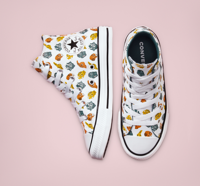
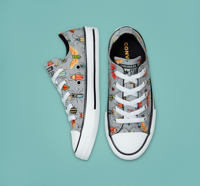
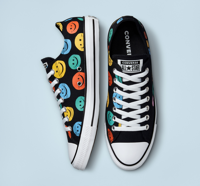
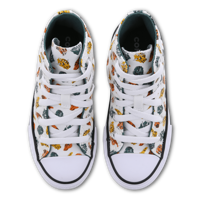
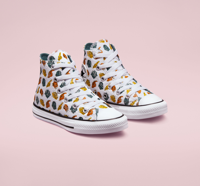
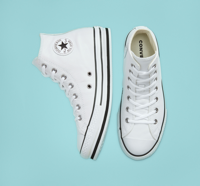
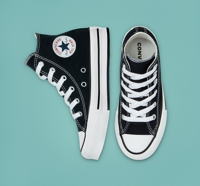
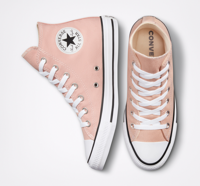
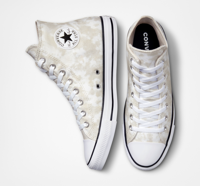
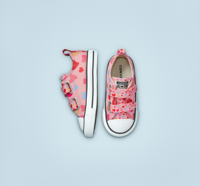
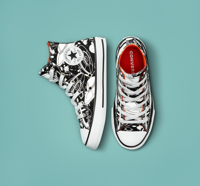
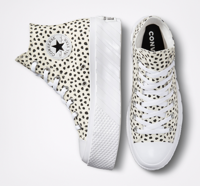
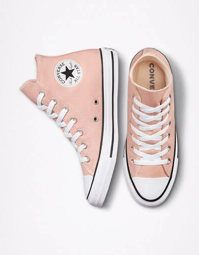
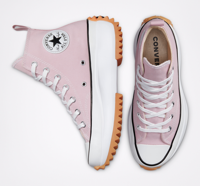
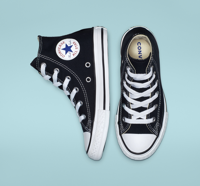
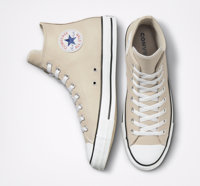
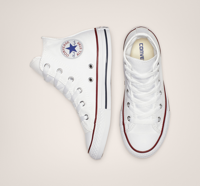
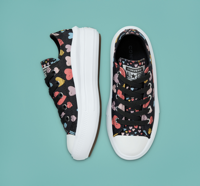
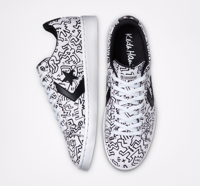
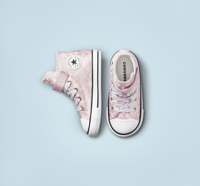


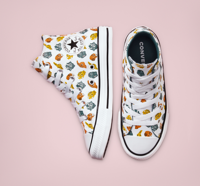
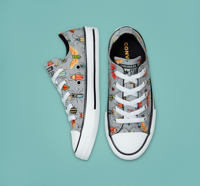
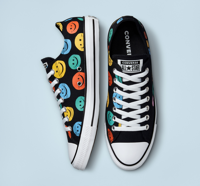
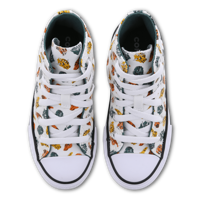
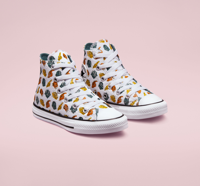
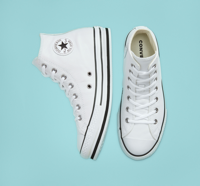
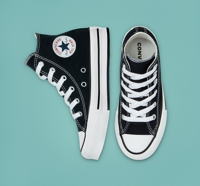
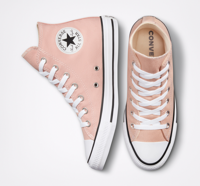
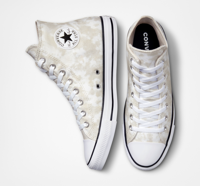
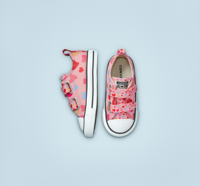
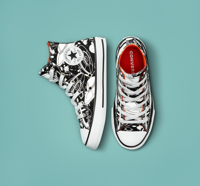
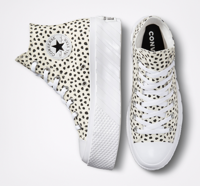
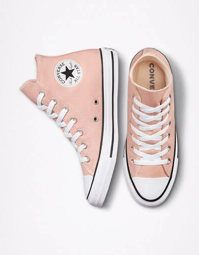
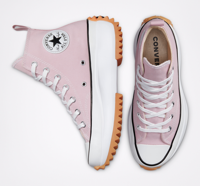
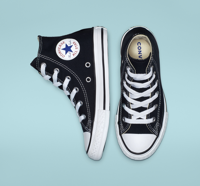
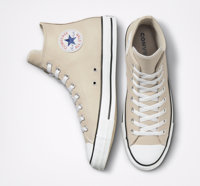
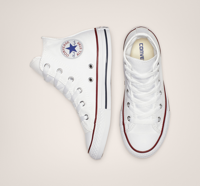
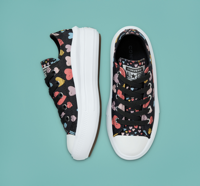
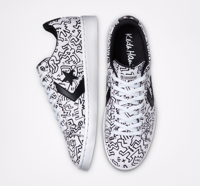
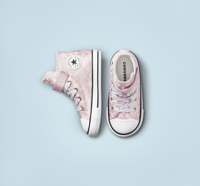

In [18]:
viz(df.iloc[NN[random.randint(0, len(NN) - 1)][:20]])

In [19]:
df["target"] = df.label.map(
        df.reset_index(drop=False).groupby("label").index.agg(list).to_dict()
    )
df.target.apply(len).value_counts().sort_index()

2       4
4      12
5      50
6      72
7     119
8     136
9     261
10    260
11    352
12    360
13    572
14    896
15    540
16    688
17    476
18    270
19    190
20    360
21    336
22    286
23    230
24    120
25    100
26    104
27    108
28     56
29     29
31     31
32     64
35     35
37     37
39     78
47     47
48     48
56     56
57     57
66     66
Name: target, dtype: int64

In [20]:
min_threshold = 0.1
max_threshold = 0.9
threshold_step = 0.05

sweep = list()
for threshold in tqdm(
    np.arange(min_threshold, max_threshold + threshold_step, threshold_step)
):
    mask = np.argwhere(np.logical_and(D < threshold, NN != -1))
    df["pred"] = (
        pd.DataFrame(mask, columns=["idx", "pred"])
        .groupby("idx", sort=False)
        .agg(list)
        .pred
    )
    scores = (
        df.apply(lambda row: compute_scores(row.pred, row.target), axis=1)
        .apply(pd.Series)
        .mean()
    )
    scores["threshold"] = threshold
    sweep.append(scores)
sweep = pd.DataFrame(sweep)
sweep

  0%|          | 0/17 [00:00<?, ?it/s]

,iou,prec,recall,fβ,f1,threshold
0,0.000178,0.001865,0.000179,0.000197,0.000322,0.10
1,0.000186,0.001905,0.000191,0.000209,0.000339,0.15
2,0.000259,0.001916,0.000279,0.000302,0.000460,0.20
3,0.000326,0.002210,0.000360,0.000388,0.000580,0.25
4,0.000386,0.002319,0.000439,0.000469,0.000681,0.30
5,0.000498,0.002186,0.000664,0.000678,0.000881,0.35
6,0.000530,0.001865,0.000856,0.000844,0.000954,0.40
7,0.000775,0.002120,0.001406,0.001357,0.001390,0.45
8,0.001321,0.002740,0.002645,0.002496,0.002342,0.50
9,0.001644,0.003120,0.003612,0.003325,0.002930,0.55
